In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Importing the RNN class and task dataset implementation
from train_rnn import MyRNN, train, simulate_with_lesions
from rnntaskdataset import RNNTaskDataset

# Define the hyperparameter search space
hidden_dims = [16, 32, 64, 128, 256, 512]
initialization_types = ['random'] # random # uniform
g_values = [0.1, 0.5, 0.9]
nonlinearities = ['tanh','relu']
tasks = ['ready_set_go', 'delay_discrimination', 'flip_flop', 'integrator']
device='cpu'

import torch.nn as nn
class myMaskedMSELoss(nn.Module):
    def __init__(self):
        super(myMaskedMSELoss, self).__init__()

    def forward(self, y_pred, y_true):
        # Create a mask that is 1 where y_true is not nan and 0 where y_true is nan
        mask = ~torch.isnan(y_true)

        # Apply the mask to y_pred and y_true
        y_pred_masked = y_pred[mask]
        y_true_masked = y_true[mask]

        # Compute MSE only for non-nan values
        loss1 = nn.functional.mse_loss(y_pred_masked, y_true_masked)
        loss2 = torch.mean((y_pred_masked-y_true_masked)**2)
        std = torch.std((y_pred_masked-y_true_masked)**2)
        all_loss = (y_pred_masked-y_true_masked)**2
        
        return loss1, loss2, std, all_loss

criterion_fn = myMaskedMSELoss()

In [2]:
all_df = []
all_percentage_silenced = [0.1,0.2,0.3] 

for percentage_silenced in all_percentage_silenced: 
    
    plot = False
    low = True
    with_noise = True
    
    dic = {
        'hidden':[],
        'g':[],
        'phi':[],
        'task':[],
    
        'connectivity_std':[],
        'activity_std':[],
        
        'log_mse_control':[],
        'std_control':[],
    
        'mse_lesion_connectivity':[],
        'std_lesion_connectivity':[],
    
        'log_mse_lesion_activity':[],
        'std_lesion_activity':[],
    
    }

    for hidden_dim in hidden_dims:
        for init_type in initialization_types:
            for g in g_values:
                for nonlinearity in nonlinearities:
                    for task in tasks:
    
                        num_silenced = int(hidden_dim * percentage_silenced)
    
                        # Append task-specific values to dictionary
                        dic['hidden'].append(hidden_dim)
                        dic['g'].append(g)
                        dic['phi'].append(nonlinearity)
                        dic['task'].append(task.split('_')[-1])
    
                        # Dataset preparation
                        task_dataset = RNNTaskDataset(n_trials=100, time=100, n_channels=2)
                        x, y = getattr(task_dataset, task)()
                        x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
                        y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
    
                        # Initialize models
                        model_params = {
                            'input_dim': x.shape[2],
                            'hidden_dim': hidden_dim,
                            'output_dim': y.shape[2],
                            'nonlinearity': nonlinearity,
                            'initialize_uniform': (init_type == "uniform"),
                            'initialize_normal': (init_type == "random"),
                            'g': g
                        }
                        model = MyRNN(**model_params).to(device)
                        model_lesion = MyRNN(**model_params).to(device)
    
                        # Load weights
                        weights_path = os.path.join('rnn_weights_2/', f"weights_{hidden_dim}_{init_type}_g{g}_{nonlinearity}_{task}.pt")
                        if not os.path.exists(weights_path):
                            weights_path = os.path.join('rnn_weights_2/', f"best_failed_weights_{hidden_dim}_{init_type}_g{g}_{nonlinearity}_{task}.pt")
    
                        model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
                        model_lesion.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
    
                        # Plotting setup
                        if plot:
                            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
    
                        # Weight matrix and connectivity standard deviation
                        weight_matrix = model.rnn.weight_hh_l0.detach().numpy()
                        dic['connectivity_std'].append(weight_matrix.std())
    
                        # Plot connectivity histogram
                        if plot:
                            ax2.set_title(f"weights_{hidden_dim}_{init_type}_g{g}_{nonlinearity}_{task}")
                            sns.histplot(ax=ax2, data=weight_matrix.flatten())
                            ax2.set_xlabel('connectivity')
    
                        # Neuron selection based on connectivity
                        ko_neurons_connectivity = np.argsort(np.abs(weight_matrix).mean(axis=0) + np.abs(weight_matrix).mean(axis=1))
                        ko_neurons_connectivity = ko_neurons_connectivity[:num_silenced] if low else ko_neurons_connectivity[-num_silenced:]
    
                        # Simulate control (without lesion)
                        all_output, all_hidden = [], []
                        hid = None
                        for i in range(x.shape[1]):
                            out, hid = model(x_tensor[:, i, :].unsqueeze(1), hid, inject_noise=with_noise)
                            all_output.append(out)
                            all_hidden.append(hid)
    
                        # Plot activity histogram
                        if plot:
                            sns.histplot(ax=ax3, data=torch.stack(all_hidden).flatten().detach().numpy())
                            ax3.set_xlabel('activity')
                        dic['activity_std'].append(torch.stack(all_hidden).flatten().detach().numpy().std())
    
                        # Neuron selection based on activity
                        all_hidden = torch.hstack(all_hidden).squeeze().detach().numpy()
                        ko_neurons_activity = np.argsort(np.abs(all_hidden).mean(axis=0))
                        ko_neurons_activity = ko_neurons_activity[:num_silenced] if low else ko_neurons_activity[-num_silenced:]
    
                        # Control MSE calculation
                        control_mean_mse, control_mean_by_hand, control_std_mse, control_raw = criterion_fn(
                            torch.hstack(all_output).squeeze().reshape(100, 100, y_tensor.size(2)), y_tensor
                        )
                        assert control_mean_mse == control_mean_by_hand
                        dic['log_mse_control'].append(control_mean_mse.item())
                        dic['std_control'].append(control_std_mse.item())
    
                        # Zero out neurons based on connectivity and reassign the weight matrix
                        for neuron in ko_neurons_connectivity:
                            weight_matrix[neuron, :] = 0
                            weight_matrix[:, neuron] = 0
                        model_lesion.rnn.weight_hh_l0.data = torch.tensor(weight_matrix)
    
                        # Simulate lesion based on connectivity
                        all_output, all_hidden = [], []
                        hid = None
                        for i in range(x.shape[1]):
                            # out, hid = model(x_tensor[:, i, :].unsqueeze(1), hid)
                            # for neuron_idx in ko_neurons_connectivity:
                            #     hid[0, :, neuron_idx] = 0  # Lesion neurons in hidden state
                                
                            out, hid = model_lesion(x_tensor[:, i, :].unsqueeze(1), hid, inject_noise=with_noise)
                            
                            all_output.append(out)
                            all_hidden.append(hid)
    
                        # MSE after connectivity lesion
                        connectivity_mean_mse, connectivity_mean_by_hand, connectivity_std_mse, connectivity_raw = criterion_fn(
                            torch.hstack(all_output).squeeze().reshape(100, 100, y_tensor.size(2)), y_tensor
                        )
                        assert connectivity_mean_mse == connectivity_mean_by_hand
                        dic['mse_lesion_connectivity'].append(connectivity_mean_mse.item())
                        dic['std_lesion_connectivity'].append(connectivity_std_mse.item())
    
                        # Simulate lesion based on activity
                        all_output, all_hidden = [], []
                        hid = None
                        for i in range(x.shape[1]):
                            out, hid = model(x_tensor[:, i, :].unsqueeze(1), hid, inject_noise=with_noise)
                            for neuron_idx in ko_neurons_activity:
                                hid[0, :, neuron_idx] = 0  # Lesion neurons in hidden state
                            all_output.append(out)
                            all_hidden.append(hid)
    
                        # MSE after activity lesion
                        activity_mean_mse, activity_mean_by_hand, activity_std_mse, activity_raw = criterion_fn(
                            torch.hstack(all_output).squeeze().reshape(100, 100, y_tensor.size(2)), y_tensor
                        )
                        assert activity_mean_mse == activity_mean_by_hand
                        dic['log_mse_lesion_activity'].append(activity_mean_mse.item())
                        dic['std_lesion_activity'].append(activity_std_mse.item())
    
                        # Save results to DataFrame and plot if required
                        data = pd.DataFrame({
                            'control': control_raw.detach().numpy(),
                            'connectivity': connectivity_raw.detach().numpy(),
                            'activity': activity_raw.detach().numpy()
                        })
    
                        if plot:
                            sns.boxplot(ax=ax1, data=data, log_scale=True)
                            ax1.set_ylabel(f'$log(mse)$')
                            sns.despine()
                            plt.tight_layout()
                            plt.show()

    df = pd.DataFrame(dic)
    all_df.append(df)

df_01 = all_df[0][['hidden', 'g', 'phi', 'task','log_mse_control','mse_lesion_connectivity','log_mse_lesion_activity']].copy()
df_01['log_log_mse_control'] = np.log(df_01['log_mse_control'])
df_01['log_mse_lesion_connectivity'] = np.log(df_01['mse_lesion_connectivity'])
df_01['log_log_mse_lesion_activity'] = np.log(df_01['log_mse_lesion_activity'])
# df_01.to_csv('data/results_0.1_lesion.csv',index=False)

df_02 = all_df[1][['hidden', 'g', 'phi', 'task','log_mse_control','mse_lesion_connectivity','log_mse_lesion_activity']].copy()
df_02['log_log_mse_control'] = np.log(df_02['log_mse_control'])
df_02['log_mse_lesion_connectivity'] = np.log(df_02['mse_lesion_connectivity'])
df_02['log_log_mse_lesion_activity'] = np.log(df_02['log_mse_lesion_activity'])
# df_02.to_csv('data/results_0.2_lesion.csv',index=False)

df_03 = all_df[2][['hidden', 'g', 'phi', 'task','log_mse_control','mse_lesion_connectivity','log_mse_lesion_activity']].copy()
df_03['log_log_mse_control'] = np.log(df_03['log_mse_control'])
df_03['log_mse_lesion_connectivity'] = np.log(df_03['mse_lesion_connectivity'])
df_03['log_log_mse_lesion_activity'] = np.log(df_03['log_mse_lesion_activity'])
# df_03.to_csv('data/results_0.3_lesion.csv',index=False)


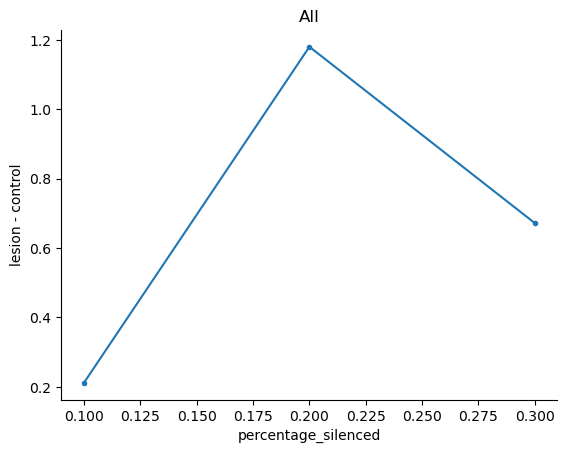

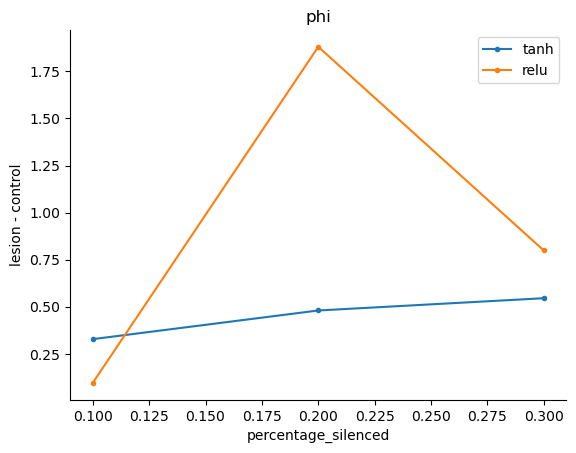

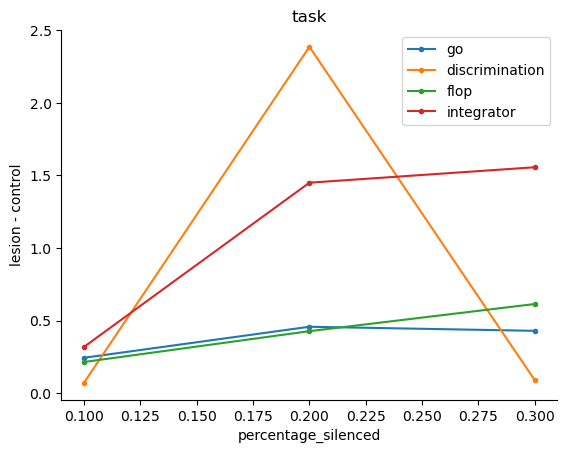

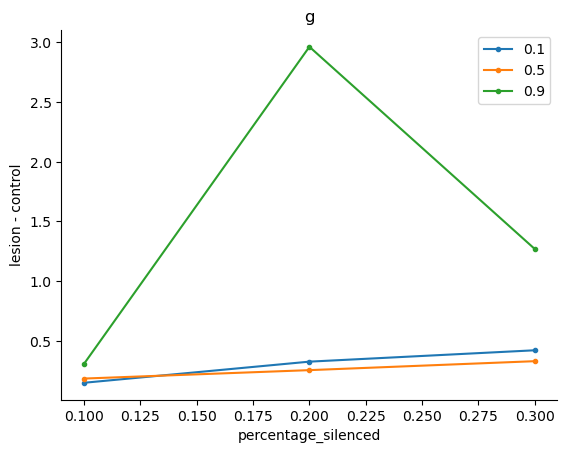

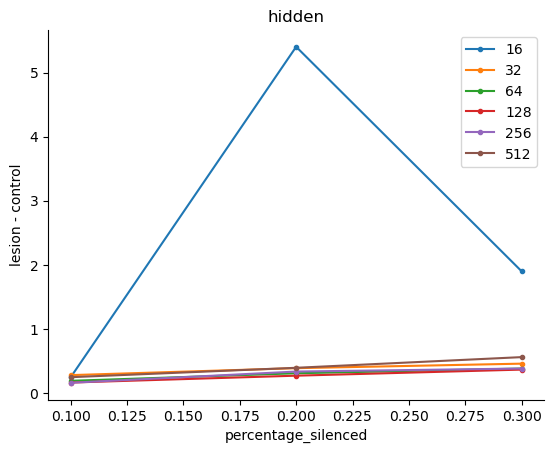

In [4]:
a = [] 
for i,p in enumerate(all_percentage_silenced):
    a.append((all_df[i].log_mse_lesion_activity - all_df[i].log_mse_control).mean())

plt.title('All')
plt.plot(all_percentage_silenced,a,'.-')
plt.xlabel('percentage_silenced')
plt.ylabel('lesion - control')
sns.despine()
plt.show()

a = [] 
b = []
for i,p in enumerate(all_percentage_silenced):
    a.append(all_df[i][all_df[i].phi=='tanh'].log_mse_lesion_activity.mean() - all_df[i][all_df[i].phi=='tanh'].log_mse_control.mean())
    b.append(all_df[i][all_df[i].phi=='relu'].log_mse_lesion_activity.mean() - all_df[i][all_df[i].phi=='relu'].log_mse_control.mean())

plt.title('phi')
plt.plot(all_percentage_silenced,a,'.-',label='tanh')
plt.plot(all_percentage_silenced,b,'.-',label='relu')
plt.legend()
plt.xlabel('percentage_silenced')
plt.ylabel('lesion - control')
sns.despine()
plt.show()

a = [] 
b = []
c = []
d = []
for i,p in enumerate(all_percentage_silenced):
    a.append(all_df[i][all_df[i].task=='go'].log_mse_lesion_activity.mean() - all_df[i][all_df[i].task=='go'].log_mse_control.mean())
    b.append(all_df[i][all_df[i].task=='discrimination'].log_mse_lesion_activity.mean() - all_df[i][all_df[i].task=='discrimination'].log_mse_control.mean())
    c.append(all_df[i][all_df[i].task=='flop'].log_mse_lesion_activity.mean() - all_df[i][all_df[i].task=='flop'].log_mse_control.mean())
    d.append(all_df[i][all_df[i].task=='integrator'].log_mse_lesion_activity.mean() - all_df[i][all_df[i].task=='integrator'].log_mse_control.mean())

plt.title('task')
plt.plot(all_percentage_silenced,a,'.-',label='go')
plt.plot(all_percentage_silenced,b,'.-',label='discrimination')
plt.plot(all_percentage_silenced,c,'.-',label='flop')
plt.plot(all_percentage_silenced,d,'.-',label='integrator')
plt.legend()
plt.xlabel('percentage_silenced')
plt.ylabel('lesion - control')
sns.despine()
plt.show()

a = [] 
b = []
c = []

for i,p in enumerate(all_percentage_silenced):
    a.append(all_df[i][all_df[i].g==.1].log_mse_lesion_activity.mean() - all_df[i][all_df[i].g==.1].log_mse_control.mean())
    b.append(all_df[i][all_df[i].g==.5].log_mse_lesion_activity.mean() - all_df[i][all_df[i].g==.5].log_mse_control.mean())
    c.append(all_df[i][all_df[i].g==.9].log_mse_lesion_activity.mean() - all_df[i][all_df[i].g==.9].log_mse_control.mean())

plt.title('g')
plt.plot(all_percentage_silenced,a,'.-',label='0.1')
plt.plot(all_percentage_silenced,b,'.-',label='0.5')
plt.plot(all_percentage_silenced,c,'.-',label='0.9')
plt.legend()
plt.xlabel('percentage_silenced')
plt.ylabel('lesion - control')
sns.despine()
plt.show()

a = [] 
b = []
c = []
d = []
e = []
f = []

for i,p in enumerate(all_percentage_silenced):
    a.append(all_df[i][all_df[i].hidden==16].log_mse_lesion_activity.mean() - all_df[i][all_df[i].hidden==16].log_mse_control.mean())
    b.append(all_df[i][all_df[i].hidden==32].log_mse_lesion_activity.mean() - all_df[i][all_df[i].hidden==32].log_mse_control.mean())
    c.append(all_df[i][all_df[i].hidden==64].log_mse_lesion_activity.mean() - all_df[i][all_df[i].hidden==64].log_mse_control.mean())
    d.append(all_df[i][all_df[i].hidden==128].log_mse_lesion_activity.mean() - all_df[i][all_df[i].hidden==128].log_mse_control.mean())
    e.append(all_df[i][all_df[i].hidden==256].log_mse_lesion_activity.mean() - all_df[i][all_df[i].hidden==256].log_mse_control.mean())
    f.append(all_df[i][all_df[i].hidden==512].log_mse_lesion_activity.mean() - all_df[i][all_df[i].hidden==512].log_mse_control.mean())

plt.title('hidden')
plt.plot(all_percentage_silenced,a,'.-',label='16')
plt.plot(all_percentage_silenced,b,'.-',label='32')
plt.plot(all_percentage_silenced,c,'.-',label='64')
plt.plot(all_percentage_silenced,d,'.-',label='128')
plt.plot(all_percentage_silenced,e,'.-',label='256')
plt.plot(all_percentage_silenced,f,'.-',label='512')
plt.legend()
plt.xlabel('percentage_silenced')
plt.ylabel('lesion - control')
sns.despine()
plt.show()


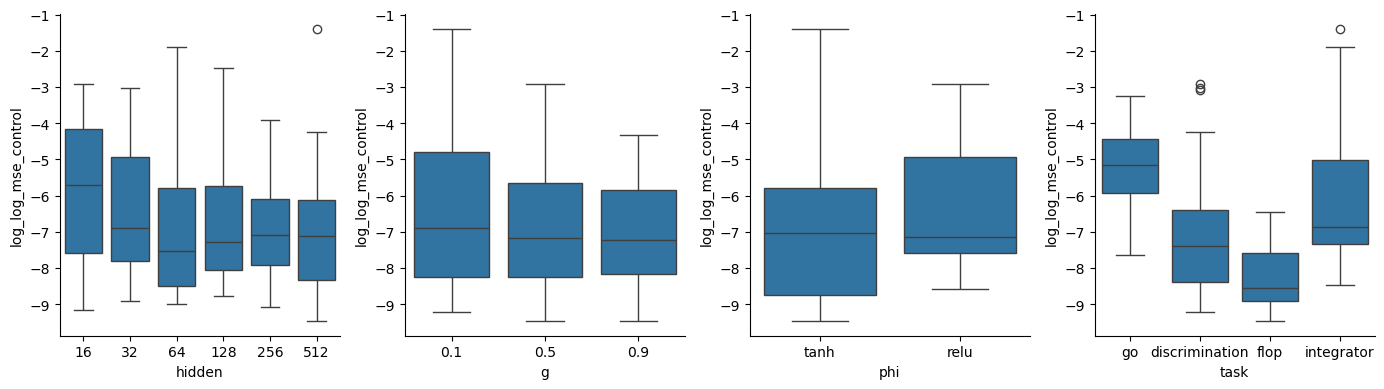

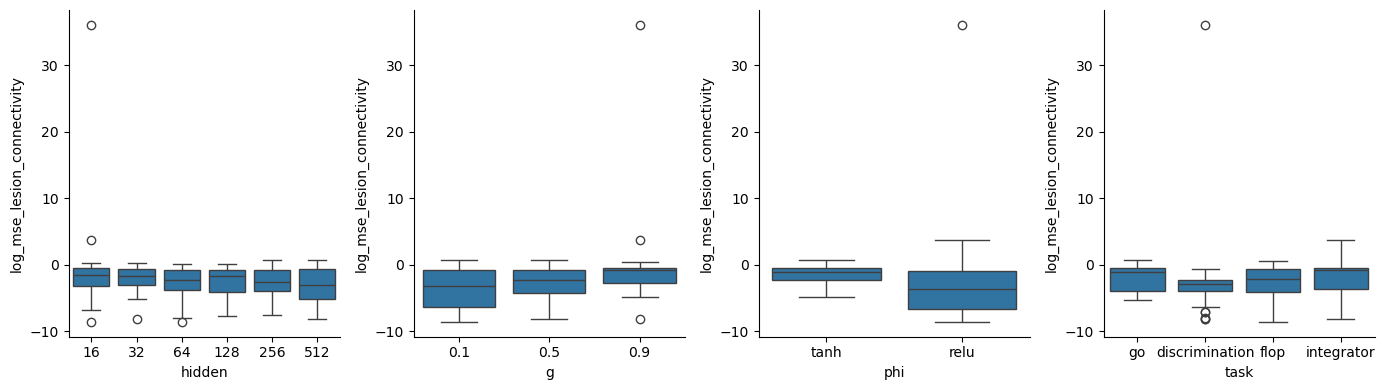

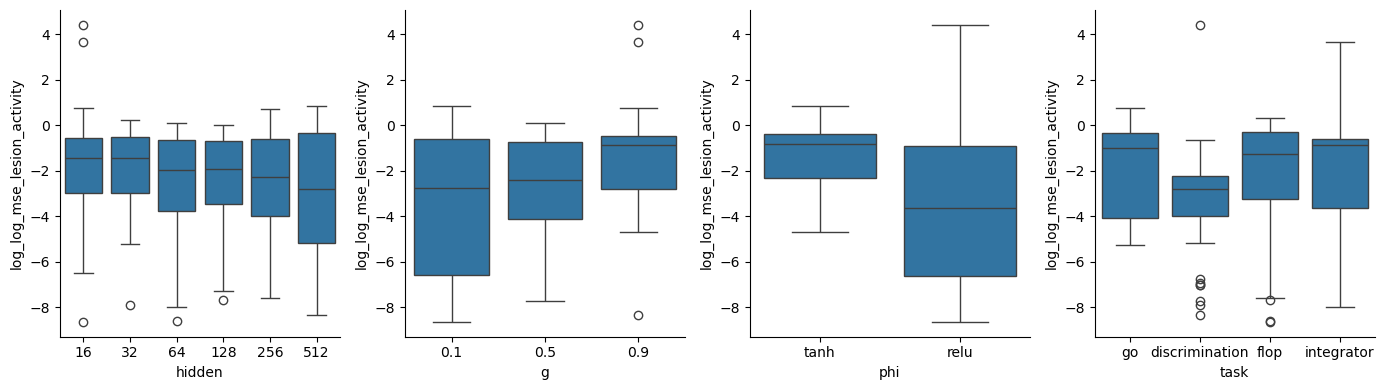

In [6]:
df = df_02

fig,ax = plt.subplots(1,4,figsize=(14,4))
n = df.columns[:4]
for i in range(4):
    sns.boxplot(ax=ax[i],data=df,x=n[i],y='log_log_mse_control')

sns.despine()
plt.tight_layout()
plt.show()


fig,ax = plt.subplots(1,4,figsize=(14,4))
n = df.columns[:4]
for i in range(4):
    sns.boxplot(ax=ax[i],data=df,x=n[i],y='log_mse_lesion_connectivity')

sns.despine()
plt.tight_layout()
plt.show()

fig,ax = plt.subplots(1,4,figsize=(14,4))
n = df.columns[:4]
for i in range(4):
    sns.boxplot(ax=ax[i],data=df,x=n[i],y='log_log_mse_lesion_activity')

sns.despine()
plt.tight_layout()
plt.show()                                              